In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
from tqdm.notebook import tqdm_notebook
from sklearn import preprocessing 
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
def custom_ensemble(xTrain,yTrain,xTest, n_estimators): 

    # Data Cleaning and Feature Engineering
    print("Data Cleaning or Feature Engineering has Started")
    xTrain, yTrain, xTest = data_cleaning(xTrain,yTrain,xTest)
    print("Data Cleaning or Feature Engineering has Completed ")

    print("*"*80)

    print("Training the data set")
    # Training the data set
    list_all_models,reg = train_model(xTrain,yTrain)
    print("Data set has been trained successfully")

    print("*"*80)

    print("Predicting the prices for xTest data")
    # Predicting the Prices for xTest
    predicted_price = prediction(xTest,xTrain,list_all_models,reg)
    print("Successfully predicted the prices for xTest data")

    # Dump the prediction in to the csv file
    predicted_price.to_csv("./output_models/output_file_custom.csv",index=False)
    print("Generated csv file for xTest with id and predicted price as columns")
    
    return predicted_price

# Function for Data Cleaning and Feature Engineering

In [3]:
def data_cleaning(xTrain,yTrain,xTest):

    xTrain['price_doc'] = yTrain

  # Cocatenating train and test dataset
    #print("Conactenating train and test data...")
    train_price = xTrain[['id','price_doc']].copy()
    train_data = xTrain.drop('price_doc',axis=1)

    X = pd.concat([train_data,xTest])
    #print("Shape of train + test data: ",X.shape)

    #print("Data cleaning/Data Preprocessing started...")

    # Drop features that has little to no variance:

    #print("Drop features that has little to no variance or useless ids...")
    zero_variance = ["culture_objects_top_25_raion", "oil_chemistry_raion", "railroad_terminal_raion", "nuclear_reactor_raion",
                "build_count_foam", "big_road1_1line", "railroad_1line", "office_sqm_500", "trc_sqm_500",
                "cafe_count_500_price_4000", "cafe_count_500_price_high", "mosque_count_500", "leisure_count_500",
				"office_sqm_1000", "trc_sqm_1000", "cafe_count_1000_price_high", "mosque_count_1000", "cafe_count_1500_price_high",
				"mosque_count_1500", "cafe_count_2000_price_high"]
    
    useless_ids = ["ID_metro", "ID_railroad_station_walk", "ID_railroad_station_avto", "ID_big_road1", "ID_big_road2",
			   "ID_railroad_terminal", "ID_bus_terminal"]

    #Sb_all.drop(zero_variance + useless_ids, axis = 1, inplace = True)

    corr = xTrain.corr()
    #Correlation with output variable 
    cor_target = abs(corr["price_doc"])
    #Selecting highly correlated features
    #relevant_features = cor_target[cor_target<=0.05]
    #useless_ids = [ i for i in X.columns if 'ID' in i.split('_') ]

    X.drop(zero_variance + useless_ids, axis = 1, inplace = True)
    #print("After droping rows which has little or no variance the shape of dataset is: ",X.shape)

    # Replace Irrevant data from relevant one

    #print("Replace Irrevant data from relevant one...")

    # State
    X.state.replace({33:3},inplace=True)

    # Material
    X['material'].replace(to_replace = 3, value = 1, inplace = True)

    # full_sq
    X['full_sq'].replace(to_replace = 0, value = np.nan, inplace = True)

    # Max Floor
    X['max_floor'].replace(to_replace = 0, value = np.nan, inplace = True)

    # Number of Rooms
    X['num_room'].replace(to_replace = 0, value = np.nan, inplace = True)

    # Feature Engineering #

    #print("Doing Feature Engineering ")

    # Additional timestamp variables:
    X['year'] = X['timestamp'].apply(lambda x: int(x[0:4]))
    X['year_mo'] = X['timestamp'].apply(lambda x: x[0:7])


    # Residential & kitchen area to total area ratio:
    X['resident_to_total_ratio'] = X['life_sq']/X['full_sq']

    # Average area per room:
    X['avg_room_area'] = X['life_sq']/X['num_room']

    # Extra area:
    X['extra_area'] = X['full_sq'] - X['life_sq']
    X['extra_area_ratio'] = X['extra_area']/X['full_sq']

    # Percentage of population in labor force:
    X['pct_labor_force'] = X['work_all']/X['raion_popul']

    # Apartment floor relative to building height:
    X['floor_rel_total'] = X['floor']/X['max_floor']


    # Some additional binary variables:
    X['metro_flag'] = np.where(X['raion_popul'] > 150000, 1, 0)
    X['large_flag'] = np.where(X['max_floor'] >= 20, 1, 0)
    X['small_flag'] = np.where(X['max_floor'] <= 20, 1, 0)

    # Average building height for subarea:
    sub_area_means = X.groupby('sub_area').agg({'max_floor':np.mean}).reset_index().rename(columns={'max_floor':'mean_bldg_height'})
    X = pd.merge(X, sub_area_means, on = ['sub_area'], how = 'left')

    # Sales by month:
    n_sales_months = X.groupby('year_mo').size().reset_index().rename(columns={0:'n_sales_month'})
    X = pd.merge(X, n_sales_months, on = ['year_mo'], how = 'left')

    # Average distance to Kremlin by subarea:
    dist_to_kremlin = X.groupby('sub_area').agg({'kremlin_km':np.nanmean}).reset_index().rename(columns={'kremlin_km':'subarea_dist_to_kremlin'})
    X = pd.merge(X, dist_to_kremlin, on = ['sub_area'], how = 'left')

    # Count NaNs per row:
    X['count_nan_per_row'] = X.isnull().sum(axis = 1)

    # Apartment name:
    X['apt_name'] = X['sub_area'] + X['metro_km_avto'].astype(str).apply(lambda x: x[0:5])
    X['apt_name_yrmo'] = X['apt_name'] + X['year_mo']

    #***********Missing value Imputation Start ***************************************************
 
    # Select all the columns having missing values less than equal to 30%
    missing_values = ((X.isna().sum())/X.shape[0])*100
    missing_values.sort_values(ascending=False,inplace = True)

    missing_values[(missing_values>0) & (missing_values<=30)].index
    values = {'prom_part_5000': X['prom_part_5000'].median(),
          'floor': X['floor'].median(),
          'railroad_station_walk_km': X['railroad_station_walk_km'].median(),
          'metro_min_walk': X['metro_min_walk'].median(),
          'metro_km_walk': X['metro_km_walk'].median(),
          'railroad_station_walk_min': X['railroad_station_walk_min'].median(),
          'product_type': X['product_type'].mode()[0],
          'green_part_2000': X['green_part_2000'].median(),
          'full_sq': X['full_sq'].median(),
         'floor_rel_total': X['floor_rel_total'].median(),
          'max_floor': X['max_floor'].median(),
          'num_room': X['num_room'].median(),
          'material': X['material'].median(),
          'preschool_quota': X['preschool_quota'].median(),
          'cafe_sum_1000_min_price_avg': X['cafe_sum_1000_min_price_avg'].median(),
          'cafe_sum_1000_max_price_avg': X['cafe_sum_1000_max_price_avg'].median(),
           'cafe_avg_price_1000': X['cafe_avg_price_1000'].median(),
          'extra_area': X['extra_area'].median(),
          'resident_to_total_ratio': X['resident_to_total_ratio'].median(),
          'extra_area_ratio': X['extra_area_ratio'].median(),
           'life_sq': X['life_sq'].median(),
           'build_count_before_1920': X['build_count_before_1920'].median(),
           'build_count_brick': X['build_count_brick'].median(),
           'build_count_1946-1970': X['build_count_1946-1970'].median(),
           'raion_build_count_with_builddate_info': X['raion_build_count_with_builddate_info'].median(),  
          'build_count_monolith': X['build_count_monolith'].median(),
          'raion_build_count_with_material_info': X['raion_build_count_with_material_info'].median(),
          'cafe_avg_price_1500': X['cafe_avg_price_1500'].median(),
          'cafe_sum_1500_min_price_avg': X['cafe_sum_1500_min_price_avg'].median(),
          'cafe_sum_1500_max_price_avg': X['cafe_sum_1500_max_price_avg'].median(),
          'cafe_avg_price_2000': X['cafe_avg_price_2000'].median(),
          'cafe_sum_2000_min_price_avg': X['cafe_sum_2000_min_price_avg'].median(),
          'cafe_sum_2000_max_price_avg': X['cafe_sum_2000_max_price_avg'].median()
         }

                        
    X.fillna(value=values,inplace=True)

    # Select all the columns having missing values greater than 30%
    missing_values[(missing_values>30)].index

    col = ['hospital_beds_raion','avg_room_area','state']

    knn_model = dict()
    for i in col:
       imputer = KNNImputer(n_neighbors=5)
       X[i] = imputer.fit_transform(X[[i]])
       knn_model[i] = imputer

    pickle.dump((knn_model),open('./output_models/model_var_knn.pkl','wb'))


    #***********Missing value Imputation End ***************************************************

    #print("Data cleaning/Data preprocessing ended Successfully!!")

    #print(" Checking if we have any null value present in the dataset or not: ",X.isnull().values.any())

    # Seperate train and test
    #print("Seperating Train and Test Data....")

    xTrain = X[X['id'].isin(train_price['id'])]
    xTrain = pd.merge(xTrain, train_price, on = ['id'], how = 'inner')
    #print(xTrain.shape)

    xTest = X[~X['id'].isin(train_price['id'])]
    #print("Shape of Test data : ",xTest.shape)

    yTrain = xTrain['price_doc'].apply(lambda x: np.log1p(x))
    xTrain.drop(columns=['id','timestamp','price_doc'],axis=1,inplace=True)

    #print("#print Shape of train data : ",xTrain.shape)

    return xTrain,yTrain,xTest


# Function for generating Samples 

In [4]:
def generating_samples(input_data, target_data):
     
    selected_rows = random.sample(range(len(input_data)),int(len(input_data)*0.65))  
    sample_data = list()
    target_sample_data = list()
    
    for i in selected_rows:
      sample_data.append(input_data.iloc[i])
        
    target_sample_data = target_data.iloc[selected_rows].tolist()
    
    
    
    return sample_data,target_sample_data,selected_rows

# Function to train the dataset

In [5]:
def train_model(xTrain,yTrain):
  
  #num_dict = dict()
  cat_dict = dict()

  # Splitting the xTrain in to train and test
  X_train, X_cv, y_train, y_cv = train_test_split(xTrain, yTrain, test_size=0.20,random_state=42)

  # Preparing the data 
  
  # Effect code categorical variables:

  #num = xTrain.select_dtypes(exclude=['object','int'])
  cat = xTrain.select_dtypes(include=['object']).copy()


  for c in cat:
    le = preprocessing.LabelEncoder()
    le.fit(X_train[c])

    X_cv[c] = X_cv[c].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')

    X_train[c] = le.transform(X_train[c])
    X_cv[c] = le.transform(X_cv[c])

    cat_dict[c] = le

    # Split X_train in to two equal parts 
  A1, A2, y_a1, y_a2 = train_test_split(X_train, y_train, test_size=0.50)

  # Generating n_estimators samples
  print("Generating " +str(n_estimators)+" Samples")

  list_input_data =[]
  list_output_data =[]
  list_selected_row= []

  for i in tqdm_notebook(range(n_estimators)):

      a,b,c = generating_samples(A1, y_a1)

      list_input_data.append(a)
      list_output_data.append(b)
      list_selected_row.append(c)

  list_all_models = list()

  print("Generating " +str(n_estimators)+" Base Models")
  for i in tqdm_notebook(range(len(list_input_data))):
      
      k = np.array(list_input_data[i])
      j = np.array(list_output_data[i])
        
      #model = XGBRegressor()
      model = lgb.LGBMRegressor(n_jobs=-1)
      model.fit(k,j)
      
      list_all_models.append(model)

  K_predictions = list()

  for i in list_all_models:
    K_predictions.append(i.predict(A2.values))

  K_predictions = np.array(K_predictions)
  K_predictions = K_predictions.T

  # Using Linear Regression Model
  reg = LinearRegression().fit(K_predictions, y_a2)
  

  print("Root Mean Sqaured Logarithmic Error for train data is: ",mean_squared_log_error(reg.predict(K_predictions), y_a2))

  # Testing the Model
  test_pred = list()

  for model in list_all_models:
    test_pred.append(model.predict(X_cv.values))

  test_pred = np.array(test_pred)
  test_pred = test_pred.T

  # Mean Sqaured Error for test data is:

  print("Root Mean Sqaured Logarithmic Error for test data is by :",mean_squared_log_error(reg.predict(test_pred), y_cv))

  # Saving all the variables in to pickle file
  pickle.dump((list_all_models, reg, cat_dict),open('model_var.pkl','wb'))

  return list_all_models,reg


# Function to predict the data

In [6]:
def prediction(xTest,xTrain,list_all_models,reg):
  # Predicting the house prices for test data

    test_id = xTest['id']
    xTest.drop(['id','timestamp'],axis=1,inplace=True)

    # Predict the House prices
    #Preparing test data:

    #num = xTrain.select_dtypes(exclude=['object','int'])
    cat = xTrain.select_dtypes(include=['object']).copy()


    for c in cat:
      le = preprocessing.LabelEncoder()
      le.fit(xTrain[c])

      xTest[c] = xTest[c].map(lambda s: '<unknown>' if s not in le.classes_ else s)
      le.classes_ = np.append(le.classes_, '<unknown>')

      xTest[c] = le.transform(xTest[c])

    # for c in num:
    #   min = xTrain[c].min()
    #   max = xTrain[c].max()

    #   xTest[c] = (xTest[c] - min)/(max-min)

    # Predicting the prices from the Model
    test_pred = list()

    for model in list_all_models:
      test_pred.append(model.predict(xTest.values))

    test_pred = np.array(test_pred)
    test_pred = test_pred.T

    pred = reg.predict(test_pred)
    xTest['price_doc'] = np.expm1(pred)
    
    xTest['id'] = test_id

    return xTest[['id','price_doc']]

# Calling the Function

In [9]:
%%time
xTrain = pd.read_csv('../data/train.zip')
xTest = pd.read_csv('../data/test.zip')

yTrain = xTrain['price_doc']
xTrain.drop(['price_doc'],axis=1,inplace = True)

n_estimators = 50
pred = custom_ensemble(xTrain,yTrain,xTest, n_estimators)

print(pred.head())

Data Cleaning or Feature Engineering has Started
Data Cleaning or Feature Engineering has Completed 
********************************************************************************
Training the data set
Generating 50 Samples



Generating 50 Base Models



Root Mean Sqaured Logarithmic Error for train data is:  0.0008379549763411352
Root Mean Sqaured Logarithmic Error for test data is by : 0.0008177705833592563
Data set has been trained successfully
********************************************************************************
Predicting the prices for xTest data
Successfully predicted the prices for xTest data
Generated csv file for xTest with id and predicted price as columns
          id     price_doc
30471  30474  5.466002e+06
30472  30475  8.210407e+06
30473  30476  4.442571e+06
30474  30477  5.353368e+06
30475  30478  5.182386e+06
Wall time: 4min 19s


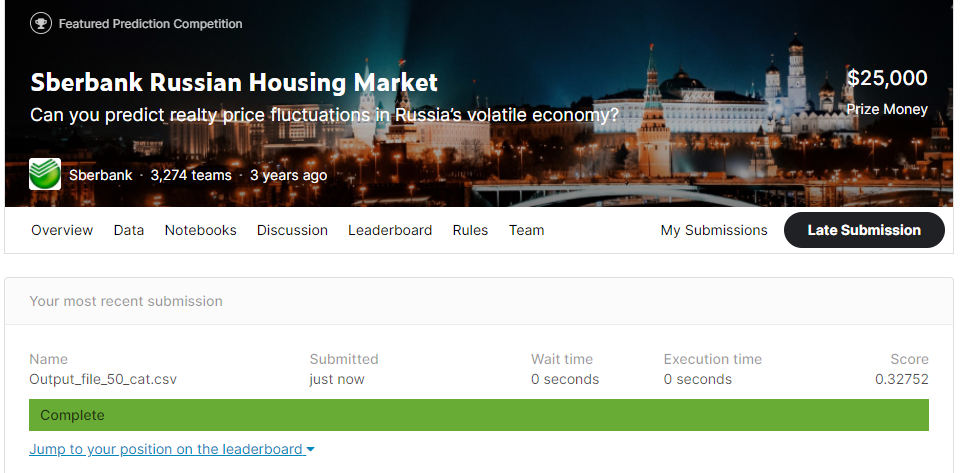